In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
%mkdir COVID19IPE
%mkdir COVID19IPE/Training
%mkdir COVID19IPE/Test
%cd COVID19IPE/Training

/content/drive/MyDrive/COVID19IPE/Training


In [ ]:
#Train Dataset
!gdown 1EtjM_HGKaWcHnxMvn33Ud0rKICt9dSKS

Downloading...
From: https://drive.google.com/uc?id=1EtjM_HGKaWcHnxMvn33Ud0rKICt9dSKS
To: /content/drive/MyDrive/COVID19IPE/Training/Train.zip
100% 804M/804M [00:10<00:00, 76.0MB/s]


In [ ]:
from zipfile import ZipFile

with ZipFile('Train.zip') as z:
  z.extractall()

In [ ]:
%rm Train.zip
%cd ../Test

# Val/Test
!gdown 1pnpG87i1uTvbMMxpsmnDuBEkQYR7n4Nb

/content/drive/MyDrive/COVID19IPE/Test
Downloading...
From: https://drive.google.com/uc?id=1pnpG87i1uTvbMMxpsmnDuBEkQYR7n4Nb
To: /content/drive/MyDrive/COVID19IPE/Test/Val Blind.zip
100% 339M/339M [00:04<00:00, 81.4MB/s]


In [ ]:
from zipfile import ZipFile

with ZipFile('Val Blind.zip') as z:
  z.extractall()

In [ ]:
%rm 'Val Blind.zip'
%cd ..

# Libraries

In [1]:
%cd /content/drive/MyDrive/COVID19IPE

/content/drive/MyDrive/COVID19IPE


In [2]:
!pip install -q pytorch_lightning timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00


In [3]:
import os, torch, torchvision,cv2, timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.model_selection import GroupKFold

sns.set_style('dark')

# Data Preparation

In [4]:
df = pd.read_csv(os.path.join('Training/', 'Train.csv'), header=None)
df.head()

,0,1,2
0,Image_0000.png,0.0,0
1,Image_0001.png,0.0,0
2,Image_0002.png,0.0,0
3,Image_0003.png,0.0,0
4,Image_0004.png,0.0,0


In [5]:
# Dataframe has no column names

df.columns = ['image', 'label', 'subject']
df.image = 'Training/' + 'Train/' + df.image
df.head()

,image,label,subject
0,Training/Train/Image_0000.png,0.0,0
1,Training/Train/Image_0001.png,0.0,0
2,Training/Train/Image_0002.png,0.0,0
3,Training/Train/Image_0003.png,0.0,0
4,Training/Train/Image_0004.png,0.0,0


In [6]:
# Create validation DF
test_path = sorted(glob(os.path.join('Test/', 'Val', '*.png')))
test_split = pd.DataFrame(test_path, columns=['image'])
image_name = [i.split('/')[-1] for i in test_path]

test_split.head()

,image
0,Test/Val/Image_0000.png
1,Test/Val/Image_0001.png
2,Test/Val/Image_0002.png
3,Test/Val/Image_0003.png
4,Test/Val/Image_0004.png


In [7]:
image_name[:5]

['Image_0000.png',
 'Image_0001.png',
 'Image_0002.png',
 'Image_0003.png',
 'Image_0004.png']

In [8]:
len(image_name)

1301

In [9]:
class DataReader(Dataset):

    def __init__(self, df, aug=False, test=False):

        self.df = df
        self.transform = aug
        self.test = test


    def __getitem__(self, index):

        file = self.df['image'][index]

        image = cv2.imread(file)
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        if self.test is False:
            label = self.df['label'][index]
            return image, label.flatten().astype('float32')

        else:
            return image


    def __len__(self):
        return len(self.df)

In [10]:
def augmentation(img_size=224):

    aug = A.Compose([A.Resize(img_size + 32, img_size + 32),
                     A.CenterCrop(img_size, img_size),
                     A.HorizontalFlip(0.5),
                     A.ShiftScaleRotate(rotate_limit=10),
                     A.Normalize(),
                     ToTensorV2(p=1.0)], p=1.0)

    return aug

aug = augmentation()

In [11]:
sample_reader = DataReader(df, aug)
sample_loader = DataLoader(sample_reader, shuffle=True, num_workers=0, batch_size=4)
batch = next(iter(sample_loader))

print(batch[0].shape, batch[1].shape)

torch.Size([4, 3, 224, 224]) torch.Size([4, 1])


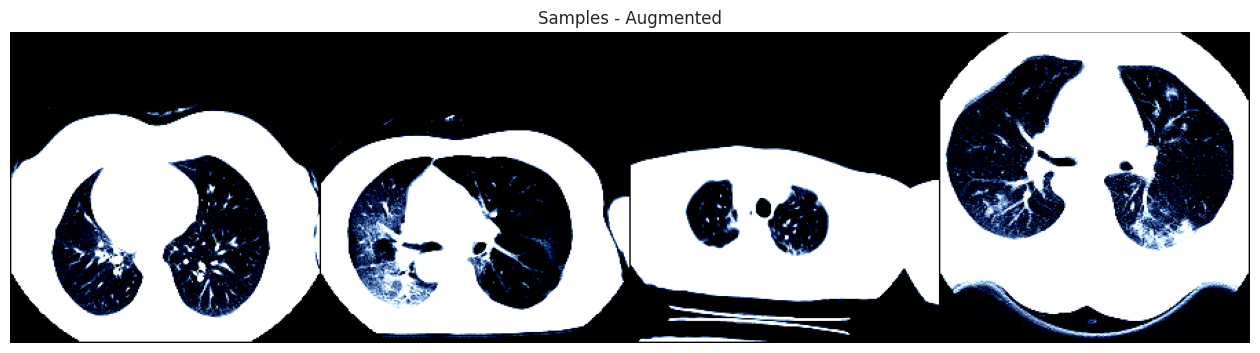

In [12]:
plt.figure(figsize=(16, 16))
grid_img = torchvision.utils.make_grid(batch[0], 4, 1)
plt.axis('off')
plt.title('Samples - Augmented')
plt.imshow(grid_img.permute(1, 2, 0))

# Modeling

In [13]:
class EstimationModel(LightningModule):

    def __init__(self, train_split, val_split):

        super(EstimationModel, self).__init__()

        self.train_split = train_split
        self.val_split = val_split

        # Architecture
        self.model = timm.create_model('efficientnet_b1', pretrained=True)

        self.fc1 = nn.Linear(1000, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 1)

        # Params
        self.lr = 1e-3
        self.batch_size = 88
        self.numworkers = 8
        self.criterion = nn.L1Loss()
        self.trainloss, self.valloss = [], []
        self.preds = 0

        self.train_step_loss_outputs = []
        self.val_step_loss_outputs = []
        self.test_step_pred_outputs = []


    def forward(self, x):

        x = self.model(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x


    def configure_optimizers(self):
        opt = torch.optim.AdamW(params=self.parameters(), lr=self.lr)
        scheduler = CosineAnnealingLR(opt, T_max=10, eta_min=1e-6, last_epoch=-1)

        return  {'optimizer': opt, 'lr_scheduler': scheduler}


    def train_dataloader(self):

        return DataLoader(DataReader(self.train_split, aug),
                          batch_size=self.batch_size, num_workers=self.numworkers,
                          pin_memory=True, shuffle=True)


    def training_step(self, batch, batch_idx):

      image, label = batch
      pred = self(image)
      loss = self.criterion(pred, label)

      self.train_step_loss_outputs.append(loss)
      # self.log('train_loss', loss, on_step=True, prog_bar=True)

      return loss


    def on_train_epoch_end(self):

      loss = torch.stack(self.train_step_loss_outputs).mean().detach().cpu().numpy().round(2)
      self.trainloss.append(loss)
      self.log('train_loss', loss, on_epoch=True, prog_bar=True)



    def val_dataloader(self):

        return DataLoader(DataReader(self.val_split, aug),
                          batch_size=self.batch_size, num_workers=self.numworkers,
                          pin_memory=True, shuffle=False)


    def validation_step(self, batch, batch_idx):

      image, label = batch
      pred = self(image)
      loss = self.criterion(pred, label)
      self.val_step_loss_outputs.append(loss)

      return loss


    def on_validation_epoch_end(self):
        loss = torch.stack(self.val_step_loss_outputs).mean().detach().cpu().numpy().round(2)
        self.valloss.append(loss)
        print('\n\n')
        self.log('val_loss', loss)


    def test_dataloader(self):

        return DataLoader(DataReader(test_split, aug, True),
                          batch_size=self.batch_size, num_workers=self.numworkers,
                          pin_memory=True, shuffle=False)


    def test_step(self, batch, batch_idx):

        image = batch
        pred = self(image)

        self.test_step_pred_outputs.append(pred)

        return pred


    def on_test_epoch_end(self):
        pred = torch.cat(self.test_step_pred_outputs).detach().cpu().numpy().ravel()
        # print('PRED Shape: ', len(pred))
        self.preds = pred


In [14]:
%mkdir models_weights

mkdir: cannot create directory ‘models_weights’: File exists


In [14]:
seed_everything(0)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
kfold = GroupKFold(n_splits=5)
train_loss, val_loss, preds, val_score = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df, groups=df.subject)):

    print(f'\n======================= FOLD No. {fold} =======================\n')

    train_split = df.loc[train_idx].reset_index(drop=True)
    val_split = df.loc[val_idx].reset_index(drop=True)

    model = EstimationModel(train_split, val_split)

    trainer = Trainer(max_epochs=1,
                      deterministic=True,
                      accelerator='gpu',
                      devices=-1,
                      precision='16-mixed',
                      accumulate_grad_batches=2,
                      log_every_n_steps=10,
                      num_sanity_val_steps=0,
                      callbacks=[lr_monitor])

    trainer.fit(model)

    train_loss.append(model.trainloss)
    val_loss.append(model.valloss)

    res = trainer.validate(model)
    val_score.append(res[0]['val_loss'])

    trainer.test(model)
    torch.save(model.state_dict(), os.path.join('models_weights', 'model_{}.pth'.format(fold)))
    preds.append(model.preds)

INFO:lightning_fabric.utilities.seed:Global seed set to 0



======================= FOLD No. 0 =======================



INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | EfficientNet | 7.8 M 
1 | fc1       | Linear       | 500 K 
2 | relu      | ReLU         | 0     
3 | fc2       | Linear       | 125 K 
4 | fc3       | Linear       | 251   
5 | criterion | L1Loss       | 0     
-------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.681    Total estimat

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     8.289999961853027     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

PRED Shape:  1301

======================= FOLD No. 1 =======================



INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | EfficientNet | 7.8 M 
1 | fc1       | Linear       | 500 K 
2 | relu      | ReLU         | 0     
3 | fc2       | Linear       | 125 K 
4 | fc3       | Linear       | 251   
5 | criterion | L1Loss       | 0     
-------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.681    Total estimat

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     7.829999923706055     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

PRED Shape:  1301

======================= FOLD No. 2 =======================



INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | EfficientNet | 7.8 M 
1 | fc1       | Linear       | 500 K 
2 | relu      | ReLU         | 0     
3 | fc2       | Linear       | 125 K 
4 | fc3       | Linear       | 251   
5 | criterion | L1Loss       | 0     
-------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.681    Total estimat

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     9.140000343322754     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

PRED Shape:  1301

======================= FOLD No. 3 =======================



INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | EfficientNet | 7.8 M 
1 | fc1       | Linear       | 500 K 
2 | relu      | ReLU         | 0     
3 | fc2       | Linear       | 125 K 
4 | fc3       | Linear       | 251   
5 | criterion | L1Loss       | 0     
-------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.681    Total estimat

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │            6.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

PRED Shape:  1301

======================= FOLD No. 4 =======================



INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | EfficientNet | 7.8 M 
1 | fc1       | Linear       | 500 K 
2 | relu      | ReLU         | 0     
3 | fc2       | Linear       | 125 K 
4 | fc3       | Linear       | 251   
5 | criterion | L1Loss       | 0     
-------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.681    Total estimat

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    13.520000457763672     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

PRED Shape:  1301


In [17]:
train_loss

[[12.81], [12.27], [11.78], [13.57], [10.46]]

In [18]:
val_loss

[[8.18, 8.29], [7.84, 7.83], [9.16, 9.14], [5.96, 6.0], [13.77, 13.52]]

In [15]:
avg = np.mean(val_score)
print('avg val loss', avg.round(4))

avg val loss 8.956


In [11]:
val_loss = [[8.18, 8.29], [7.84, 7.83], [9.16, 9.14], [5.96, 6.0], [13.77, 13.52]]
train_loss = [[12.81], [12.27], [11.78], [13.57], [10.46]]

for i in range(5):
  val_loss[i] = val_loss[i][1]

for i in range(5):
  train_loss[i] = train_loss[i][0]

val_loss, train_loss

([8.29, 7.83, 9.14, 6.0, 13.52], [12.81, 12.27, 11.78, 13.57, 10.46])

Text(0.5, 1.0, 'Training vs. Validation Loss')

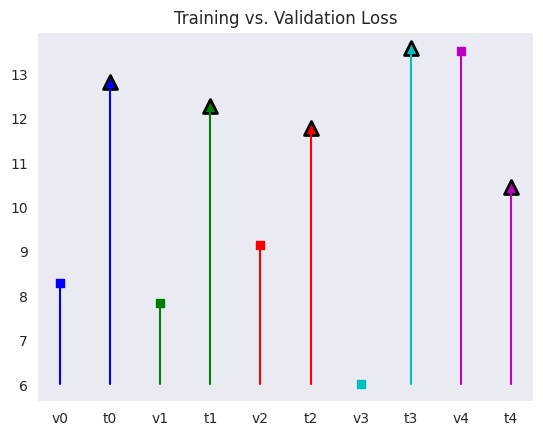

In [90]:
colors_list = ['b', 'g', 'r', 'c', 'm']
v = 0
t = 1

for i in range(5):
  plt.plot([v, v], [min(val_loss), val_loss[i]], color=colors_list[i])
  plt.scatter(f'v{i}', val_loss[i], marker='s', color=colors_list[i], s=40)

  plt.plot([t, t], [min(val_loss), train_loss[i]], color=colors_list[i])
  plt.scatter(f't{i}', train_loss[i], marker='^', linewidth=2, color=colors_list[i], edgecolor='black', s=100)

  v += 2
  t += 2

plt.title('Training vs. Validation Loss')

In [19]:
preds[0].shape

(1301,)

In [20]:
mean = np.mean(preds, 0)
mean = np.where(mean<0, 0, mean)
mean.shape

(1301,)

In [21]:
submission = pd.DataFrame(zip(image_name, mean))
submission.head()

,0,1
0,Image_0000.png,0.243164
1,Image_0001.png,0.228394
2,Image_0002.png,0.200562
3,Image_0003.png,0.370605
4,Image_0004.png,1.966797


In [22]:
submission.to_csv('predictiosn.csv', index=False, header=None)